# Import library

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import xgboost as xgb
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Data

In [4]:
train = pd.read_csv("/data/home/yjkim/DACON/Cancer/train.csv")
test = pd.read_csv("/data/home/yjkim/DACON/Cancer/test.csv")

In [5]:
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [6]:
type_df = pd.read_csv("/data/home/yjkim/DACON/Cancer/mutation_types_trainset.csv")

In [7]:
type_df

,Mutation Type,Given Mutation
0,deletion,249del
1,deletion,490del
2,deletion,R649del
3,frame_shift,A1001fs
4,frame_shift,A1004fs
...,...,...
154812,silent,873_874LL>LL
154813,silent,8_9PL>PL
154814,silent,91_92TL>TL
154815,silent,929_930LL>LL


In [17]:
types_locs_df = pd.read_csv("/data/home/yjkim/DACON/Cancer/mutation_types_locs_trainset.csv")

In [30]:
types_locs_df['Extracted Number 2'] = types_locs_df['Extracted Number 2'].apply(lambda x: int(x) if pd.notna(x) else x).astype('Int64')

In [31]:
types_locs_df['Extracted Number 2']

0         <NA>
1         <NA>
2         <NA>
3         <NA>
4         <NA>
          ... 
154812     874
154813       9
154814      92
154815     930
154816      93
Name: Extracted Number 2, Length: 154817, dtype: Int64

In [32]:
types_locs_df

,Mutation Type,Given Mutation,Extracted Number 1,Extracted Number 2
0,deletion,249del,249,<NA>
1,deletion,490del,490,<NA>
2,deletion,R649del,649,<NA>
3,frame_shift,A1001fs,1001,<NA>
4,frame_shift,A1004fs,1004,<NA>
...,...,...,...,...
154812,silent,873_874LL>LL,873,874
154813,silent,8_9PL>PL,8,9
154814,silent,91_92TL>TL,91,92
154815,silent,929_930LL>LL,929,930


# Data Preprocessing

In [37]:
# Function to construct a dictionary from the dataframe
def dataframe_to_dict(df):
    result_dict = {}
    
    for _, row in df.iterrows():
        key = row['Given Mutation']
        # If Extracted Number 2 is not NaN, include both extracted numbers, otherwise only include Extracted Number 1
        if pd.notna(row['Extracted Number 2']):
            result_dict[key] = (row['Mutation Type'], row['Extracted Number 1'], row['Extracted Number 2'])
        else:
            result_dict[key] = (row['Mutation Type'], row['Extracted Number 1'])
    
    return result_dict

In [38]:
mutation_type_loc_dict = dataframe_to_dict(types_locs_df)

In [39]:
mutation_type_loc_dict

{'249del': ('deletion', 249),
 '490del': ('deletion', 490),
 'R649del': ('deletion', 649),
 'A1001fs': ('frame_shift', 1001),
 'A1004fs': ('frame_shift', 1004),
 'A1007fs': ('frame_shift', 1007),
 'A100fs': ('frame_shift', 100),
 'A1014fs': ('frame_shift', 1014),
 'A101fs': ('frame_shift', 101),
 'A1026fs': ('frame_shift', 1026),
 'A1032fs': ('frame_shift', 1032),
 'A103fs': ('frame_shift', 103),
 'A1042fs': ('frame_shift', 1042),
 'A1052fs': ('frame_shift', 1052),
 'A1097fs': ('frame_shift', 1097),
 'A10fs': ('frame_shift', 10),
 'A110fs': ('frame_shift', 110),
 'A111fs': ('frame_shift', 111),
 'A1133fs': ('frame_shift', 1133),
 'A1145fs': ('frame_shift', 1145),
 'A114fs': ('frame_shift', 114),
 'A1177fs': ('frame_shift', 1177),
 'A119fs': ('frame_shift', 119),
 'A120fs': ('frame_shift', 120),
 'A122fs': ('frame_shift', 122),
 'A124fs': ('frame_shift', 124),
 'A125fs': ('frame_shift', 125),
 'A1265fs': ('frame_shift', 1265),
 'A1274fs': ('frame_shift', 1274),
 'A1303fs': ('frame_shift

In [9]:
embedding_dict = {}
modified_train = train.copy()

In [42]:
modified_train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [43]:
for index, row in train.iterrows():
    patient_id = row['ID'] 

    # Iterate over each genome column, skipping 'ID' and 'SUBCLASS'
    for genome in row.index[2:]:
        mutations = row[genome].split()  # Split mutations by space 
        mutations = list(set(mutations)) # unique

        # Initialize a 7-dimensional vector for each genome
        mutation_vector = [0, 0, 0, 0, 0, 0, 0]

        # Count mutations of each type for this genome
        for mutation in mutations:
            if mutation != 'WT' and mutation in mutation_type_loc_dict:
                mutation_type = mutation_type_loc_dict[mutation][0]
                if mutation_type == 'nonsense':
                    mutation_vector[0] += 1
                elif mutation_type == 'missense':
                    mutation_vector[1] += 1
                elif mutation_type == 'frame_shift':
                    mutation_vector[2] += 1
                elif mutation_type == 'silent':
                    mutation_vector[3] += 1
                elif mutation_type == 'deletion':
                    mutation_vector[4] += 1
                elif mutation_type == 'insertion':
                    mutation_vector[5] += 1
                elif mutation_type == 'deletion_insertion':
                    mutation_vector[6] += 1

        modified_train.at[index, genome] = mutation_vector
        
        embedding_dict[patient_id, genome] = mutation_vector

In [44]:
modified_train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
1,TRAIN_0001,SARC,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
2,TRAIN_0002,SKCM,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
3,TRAIN_0003,KIRC,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
4,TRAIN_0004,GBMLGG,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
6197,TRAIN_6197,LGG,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
6198,TRAIN_6198,COAD,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
6199,TRAIN_6199,TGCT,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0,

In [45]:
embedding_dict

{('TRAIN_0000', 'A2M'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'AAAS'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'AADAT'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'AARS1'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABAT'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA1'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA2'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA3'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA4'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA5'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA6'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA8'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCA9'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB1'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB11'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB4'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB6'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB7'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB8'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCB9'): [0, 0, 0, 0, 0, 0, 0],
 ('TRAIN_0000', 'ABCC1'

In [46]:
len(embedding_dict)

27185184

In [47]:
result = {k: v for k, v in embedding_dict.items() if any(x >= 2 for x in v)}

In [48]:
len(result)

12719

In [64]:
result

{('TRAIN_0002', 'MYH4'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0002', 'TNC'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0005', 'ADCY9'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0005', 'ALDH3A1'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0005', 'HDAC9'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0005', 'JAK2'): [0, 0, 2, 0, 0, 0, 0],
 ('TRAIN_0005', 'MMP2'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0005', 'PAOX'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0005', 'RHOBTB3'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0005', 'RPTOR'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'ABCA1'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'BMP2'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0014', 'EZR'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'LCT'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'LEPR'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'MARCO'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'MXRA5'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'MYH9'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0014', 'MYOF'): [0, 0, 0, 2, 0, 0, 0],
 ('TRAIN_0014', 'RB1'): [0, 2, 0, 0, 0, 0, 0],
 ('TRAIN_0014', 'SORBS2'): [0, 2

In [70]:
from collections import defaultdict
count_dict = defaultdict(int)

In [71]:
for key in result.keys():
    first_element = key[0]  # Split by '_' and take the first element
    count_dict[first_element] += 1

In [72]:
count_dict

defaultdict(int,
            {'TRAIN_0002': 2,
             'TRAIN_0005': 8,
             'TRAIN_0014': 13,
             'TRAIN_0022': 1,
             'TRAIN_0024': 7,
             'TRAIN_0029': 2,
             'TRAIN_0030': 1,
             'TRAIN_0032': 1,
             'TRAIN_0041': 3,
             'TRAIN_0042': 1,
             'TRAIN_0044': 2,
             'TRAIN_0045': 1,
             'TRAIN_0047': 10,
             'TRAIN_0048': 1,
             'TRAIN_0050': 1,
             'TRAIN_0054': 4,
             'TRAIN_0058': 30,
             'TRAIN_0060': 1,
             'TRAIN_0071': 183,
             'TRAIN_0073': 12,
             'TRAIN_0074': 3,
             'TRAIN_0076': 1,
             'TRAIN_0078': 6,
             'TRAIN_0080': 1,
             'TRAIN_0082': 1,
             'TRAIN_0086': 1,
             'TRAIN_0087': 16,
             'TRAIN_0090': 1,
             'TRAIN_0092': 8,
             'TRAIN_0093': 1,
             'TRAIN_0094': 11,
             'TRAIN_0097': 1,
             'T

In [75]:
filtered_dict = {key: value for key, value in count_dict.items() if value > 10}

In [76]:
filtered_dict

{'TRAIN_0014': 13,
 'TRAIN_0058': 30,
 'TRAIN_0071': 183,
 'TRAIN_0073': 12,
 'TRAIN_0087': 16,
 'TRAIN_0094': 11,
 'TRAIN_0116': 11,
 'TRAIN_0273': 12,
 'TRAIN_0286': 16,
 'TRAIN_0322': 13,
 'TRAIN_0354': 100,
 'TRAIN_0395': 12,
 'TRAIN_0406': 170,
 'TRAIN_0469': 21,
 'TRAIN_0486': 122,
 'TRAIN_0495': 21,
 'TRAIN_0520': 129,
 'TRAIN_0561': 13,
 'TRAIN_0562': 13,
 'TRAIN_0570': 13,
 'TRAIN_0601': 178,
 'TRAIN_0682': 105,
 'TRAIN_0717': 13,
 'TRAIN_0720': 15,
 'TRAIN_0736': 16,
 'TRAIN_0755': 20,
 'TRAIN_0877': 50,
 'TRAIN_1044': 42,
 'TRAIN_1081': 14,
 'TRAIN_1091': 22,
 'TRAIN_1159': 18,
 'TRAIN_1174': 16,
 'TRAIN_1202': 309,
 'TRAIN_1232': 87,
 'TRAIN_1235': 46,
 'TRAIN_1253': 22,
 'TRAIN_1274': 25,
 'TRAIN_1334': 70,
 'TRAIN_1362': 34,
 'TRAIN_1369': 783,
 'TRAIN_1405': 12,
 'TRAIN_1490': 20,
 'TRAIN_1502': 231,
 'TRAIN_1566': 15,
 'TRAIN_1674': 20,
 'TRAIN_1758': 14,
 'TRAIN_1761': 443,
 'TRAIN_1774': 24,
 'TRAIN_1789': 888,
 'TRAIN_1828': 12,
 'TRAIN_1883': 100,
 'TRAIN_1924': 27,

In [65]:
a = set()
for key in result.keys():
    a.add(key[0])

In [66]:
len(a)

1499

In [67]:
a

{'TRAIN_3898',
 'TRAIN_1935',
 'TRAIN_1490',
 'TRAIN_0111',
 'TRAIN_3458',
 'TRAIN_1208',
 'TRAIN_2312',
 'TRAIN_2065',
 'TRAIN_4339',
 'TRAIN_2920',
 'TRAIN_1904',
 'TRAIN_0487',
 'TRAIN_3138',
 'TRAIN_4743',
 'TRAIN_2762',
 'TRAIN_4191',
 'TRAIN_0679',
 'TRAIN_4570',
 'TRAIN_2360',
 'TRAIN_2785',
 'TRAIN_4543',
 'TRAIN_0821',
 'TRAIN_1796',
 'TRAIN_1085',
 'TRAIN_4548',
 'TRAIN_5105',
 'TRAIN_4945',
 'TRAIN_4871',
 'TRAIN_4085',
 'TRAIN_1223',
 'TRAIN_2738',
 'TRAIN_4383',
 'TRAIN_5428',
 'TRAIN_1525',
 'TRAIN_3661',
 'TRAIN_5754',
 'TRAIN_3040',
 'TRAIN_0931',
 'TRAIN_2350',
 'TRAIN_0514',
 'TRAIN_5480',
 'TRAIN_5126',
 'TRAIN_1485',
 'TRAIN_3323',
 'TRAIN_3095',
 'TRAIN_5076',
 'TRAIN_1230',
 'TRAIN_0646',
 'TRAIN_2541',
 'TRAIN_2376',
 'TRAIN_3497',
 'TRAIN_1330',
 'TRAIN_3232',
 'TRAIN_1189',
 'TRAIN_4739',
 'TRAIN_4749',
 'TRAIN_1108',
 'TRAIN_2835',
 'TRAIN_0776',
 'TRAIN_1821',
 'TRAIN_2984',
 'TRAIN_3646',
 'TRAIN_5216',
 'TRAIN_5627',
 'TRAIN_1186',
 'TRAIN_0469',
 'TRAIN_54

In [68]:
a = list(a)
a.sort()

In [69]:
a

['TRAIN_0002',
 'TRAIN_0005',
 'TRAIN_0014',
 'TRAIN_0022',
 'TRAIN_0024',
 'TRAIN_0029',
 'TRAIN_0030',
 'TRAIN_0032',
 'TRAIN_0041',
 'TRAIN_0042',
 'TRAIN_0044',
 'TRAIN_0045',
 'TRAIN_0047',
 'TRAIN_0048',
 'TRAIN_0050',
 'TRAIN_0054',
 'TRAIN_0058',
 'TRAIN_0060',
 'TRAIN_0071',
 'TRAIN_0073',
 'TRAIN_0074',
 'TRAIN_0076',
 'TRAIN_0078',
 'TRAIN_0080',
 'TRAIN_0082',
 'TRAIN_0086',
 'TRAIN_0087',
 'TRAIN_0090',
 'TRAIN_0092',
 'TRAIN_0093',
 'TRAIN_0094',
 'TRAIN_0097',
 'TRAIN_0103',
 'TRAIN_0105',
 'TRAIN_0110',
 'TRAIN_0111',
 'TRAIN_0113',
 'TRAIN_0116',
 'TRAIN_0125',
 'TRAIN_0127',
 'TRAIN_0134',
 'TRAIN_0139',
 'TRAIN_0141',
 'TRAIN_0142',
 'TRAIN_0145',
 'TRAIN_0150',
 'TRAIN_0153',
 'TRAIN_0157',
 'TRAIN_0158',
 'TRAIN_0167',
 'TRAIN_0172',
 'TRAIN_0183',
 'TRAIN_0191',
 'TRAIN_0194',
 'TRAIN_0202',
 'TRAIN_0209',
 'TRAIN_0211',
 'TRAIN_0212',
 'TRAIN_0215',
 'TRAIN_0217',
 'TRAIN_0218',
 'TRAIN_0222',
 'TRAIN_0229',
 'TRAIN_0230',
 'TRAIN_0231',
 'TRAIN_0234',
 'TRAIN_02

In [13]:
matrix_embeddings = {}

for index, row in modified_train.iterrows():
    patient_id = row['ID']
    patient_matrix = np.zeros((7, len(train.columns) - 2)) # shape: 7x4384

    for idx, genome in enumerate(train.columns[2:]):
        mutation_vector = embedding_dict[(patient_id, genome)]
        patient_matrix[:, idx] = mutation_vector

    matrix_embeddings[patient_id] = patient_matrix

print(matrix_embeddings['TRAIN_0000'])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
matrix_embeddings['TRAIN_0000'].shape

(7, 4384)

In [10]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


In [21]:
X_encoded = np.array([matrix_embeddings[patient_id] for patient_id in modified_train['ID']])
y_subclass = train['SUBCLASS'].values

In [22]:
X_encoded

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [18]:
y_subclass

array([ 8, 19, 20, ...,  4, 22, 20])

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

In [44]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=8, num_encoder_layers=6, dim_feedforward=512, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.embedding(x)
        #x = x.permute(1, 0, 2) # transformer input format : sequence length, batch size, d_model(4384)=input size?
        transformer_out = self.transformer(x, x)
        transformer_out = transformer_out.mean(dim=1)
        out = self.fc(transformer_out)
        return out

In [33]:
X_train_tensor.shape

torch.Size([4960, 7, 4384])

In [45]:
input_dim = X_train_tensor.shape[2] #4384
num_classes = len(le_subclass.classes_)
model = TransformerClassifier(input_dim=input_dim, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
num_epochs = 50
best_f1 = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        
        val_f1 = f1_score(y_val_tensor.cpu(), val_preds.cpu(), average='macro')
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_transformer_model.pth')
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val F1: {val_f1:.4f}")

    model.load_state_dict(torch.load('best_transformer_model.pth'))

Epoch 1/50, Loss: 3.3492, Val Loss: 3.2937, Val F1: 0.0040
Epoch 2/50, Loss: 3.2256, Val Loss: 3.2172, Val F1: 0.0082
Epoch 3/50, Loss: 3.2029, Val Loss: 3.1845, Val F1: 0.0082
Epoch 4/50, Loss: 3.2013, Val Loss: 3.1878, Val F1: 0.0082
Epoch 5/50, Loss: 3.2031, Val Loss: 3.1977, Val F1: 0.0082
Epoch 6/50, Loss: 3.2026, Val Loss: 3.2073, Val F1: 0.0082
Epoch 7/50, Loss: 3.2001, Val Loss: 3.2159, Val F1: 0.0082
Epoch 8/50, Loss: 3.2036, Val Loss: 3.2239, Val F1: 0.0082
Epoch 9/50, Loss: 3.2009, Val Loss: 3.2308, Val F1: 0.0082
Epoch 10/50, Loss: 3.2022, Val Loss: 3.2366, Val F1: 0.0082
Epoch 11/50, Loss: 3.2023, Val Loss: 3.2416, Val F1: 0.0082
Epoch 12/50, Loss: 3.2023, Val Loss: 3.2464, Val F1: 0.0082
Epoch 13/50, Loss: 3.2022, Val Loss: 3.2507, Val F1: 0.0082
Epoch 14/50, Loss: 3.2017, Val Loss: 3.2548, Val F1: 0.0082
Epoch 15/50, Loss: 3.2024, Val Loss: 3.2584, Val F1: 0.0082
Epoch 16/50, Loss: 3.2010, Val Loss: 3.2616, Val F1: 0.0082
Epoch 17/50, Loss: 3.2033, Val Loss: 3.2644, Val 

In [21]:
# Function to calculate Macro F1 Score
def macro_f1_score(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds, axis=1)
    f1 = f1_score(labels, preds, average='macro')
    return 'macro_f1', f1

# Model Define and Train

In [22]:
# XGBoost Parameters for GPU
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(le_subclass.classes_),
    'learning_rate': 0.1,
    'max_depth': 6,
    'eval_metric': 'mlogloss',
    'tree_method': 'gpu_hist',  # GPU-accelerated tree construction
    'predictor': 'gpu_predictor',  # GPU-based prediction
    'use_label_encoder': False,
    'random_state': 42
}

In [23]:
# Train the model with evaluation sets
evals = [(dtrain, 'train'), (dval, 'validation')]
evals_result = {}

In [25]:
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=evals,
    evals_result=evals_result,
    feval=macro_f1_score,  # Custom evaluation function for macro F1 score
    maximize=True,  # Maximizing the F1 score
    early_stopping_rounds=20,  # Stop if no improvement in 10 rounds
    verbose_eval=True
)

/data/home/yjkim/.conda/envs/GNN_DDI/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/data/home/yjkim/.conda/envs/GNN_DDI/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:19:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/data/home/yjkim/.conda/envs/GNN_DDI/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:19:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:3.03750	train-macro_f1:0.33590	validation-mlogloss:3.07006	validation-macro_f1:0.27142
[1]	train-mlogloss:2.89879	train-macro_f1:0.34586	validation-mlogloss:2.95466	validation-macro_f1:0.27977
[2]	train-mlogloss:2.79072	train-macro_f1:0.36182	validation-mlogloss:2.86816	validation-macro_f1:0.29454
[3]	train-mlogloss:2.70229	train-macro_f1:0.37542	validation-mlogloss:2.79592	validation-macro_f1:0.29898
[4]	train-mlogloss:2.62678	train-macro_f1:0.37730	validation-mlogloss:2.73557	validation-macro_f1:0.30126
[5]	train-mlogloss:2.56083	train-macro_f1:0.38775	validation-mlogloss:2.68471	validation-macro_f1:0.31461
[6]	train-mlogloss:2.50183	train-macro_f1:0.39076	validation-mlogloss:2.64199	validation-macro_f1:0.30706
[7]	train-mlogloss:2.44953	train-macro_f1:0.39926	validation-mlogloss:2.60096	validation-macro_f1:0.30718
[8]	train-mlogloss:2.40056	train-macro_f1:0.40825	validation-mlogloss:2.56502	validation-macro_f1:0.30942
[9]	train-mlogloss:2.35652	train-macro_f1:0.41

In [26]:
# Display evaluation results
print(f"Training and validation results: {evals_result}")

Training and validation results: {'train': OrderedDict([('mlogloss', [3.037495456828225, 2.8987867302952273, 2.7907183513045313, 2.7022913446349484, 2.626776995365658, 2.560832308521194, 2.5018282875298494, 2.449532507996886, 2.400557018251669, 2.356515192312579, 2.31677352520487, 2.2793202696308015, 2.2451912547551816, 2.2124479199909874, 2.182585189215118, 2.154211688324088, 2.127103821873184, 2.102729165884516, 2.078991101153435, 2.055583922751248, 2.0343023983461244, 2.0131570644977113, 1.993850530930344, 1.974527270482072, 1.9571961616015723, 1.9397584419457181]), ('macro_f1', [0.335902, 0.345857, 0.361816, 0.375424, 0.377299, 0.387748, 0.390759, 0.399261, 0.408247, 0.413266, 0.418321, 0.423606, 0.428103, 0.436874, 0.440098, 0.442418, 0.448195, 0.455267, 0.461233, 0.464796, 0.468765, 0.476439, 0.479253, 0.484498, 0.488857, 0.494524])]), 'validation': OrderedDict([('mlogloss', [3.070057298174604, 2.9546617525993675, 2.8681598547290736, 2.795922309520454, 2.73557490451407, 2.6847081

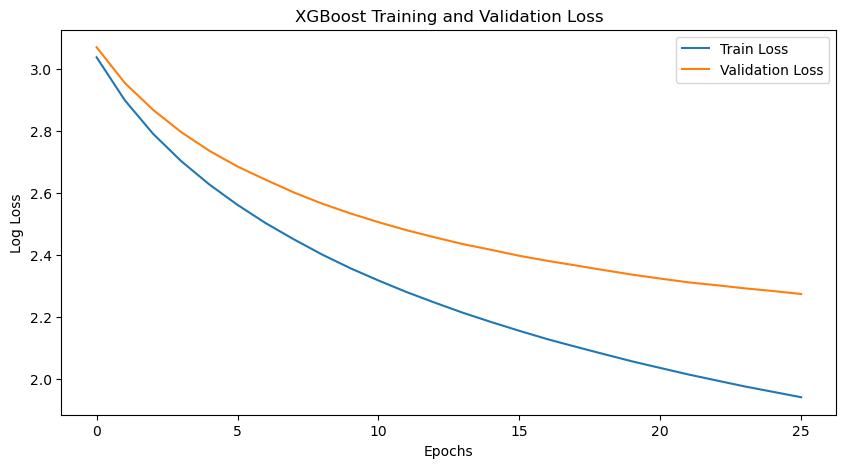

In [27]:
# Plot training and validation loss
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Loss')
plt.plot(x_axis, evals_result['validation']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.show()

# Inference

In [18]:
test_X = test.drop(columns=['ID'])
X_encoded = test_X.copy()
X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])

In [20]:
# Convert test data to DMatrix
dtest = xgb.DMatrix(X_encoded)

In [22]:
predictions = bst.predict(dtest)

/data/home/yjkim/.conda/envs/GNN_DDI/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:16:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [25]:
original_labels = le_subclass.inverse_transform(predictions.astype(int))